In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!pip install catboost
!pip install lightgbm

In [20]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load Dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rp/Bicep_Detection_Dataset.csv')
df.head()

,Myoware,X-axis,Y-axis,Z-axis,Output
0,254,-7.50,0.25,-0.22,Bicep_Correct_Form
1,313,-7.72,-0.59,-0.41,Bicep_Correct_Form
2,387,-7.56,-0.56,-0.44,Bicep_Correct_Form
3,324,-7.75,-0.19,-0.41,Bicep_Correct_Form
4,268,-7.75,-0.12,-0.22,Bicep_Correct_Form


In [4]:
# Encode Labels
le = LabelEncoder()
df['Output'] = le.fit_transform(df['Output'])  # 0 = incorrect, 1 = correct
df.head()

,Myoware,X-axis,Y-axis,Z-axis,Output
0,254,-7.50,0.25,-0.22,0
1,313,-7.72,-0.59,-0.41,0
2,387,-7.56,-0.56,-0.44,0
3,324,-7.75,-0.19,-0.41,0
4,268,-7.75,-0.12,-0.22,0


In [5]:
# Features and Target
X = df.drop('Output', axis=1)
y = df['Output']

In [6]:
# XGBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:50:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [7]:
# Performance Metrices
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the XGBoost Classifier: {accuracy*100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy of the XGBoost Classifier: 91.50%

Confusion Matrix:
[[518  24]
 [ 61 397]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       542
           1       0.94      0.87      0.90       458

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.92      0.91      1000



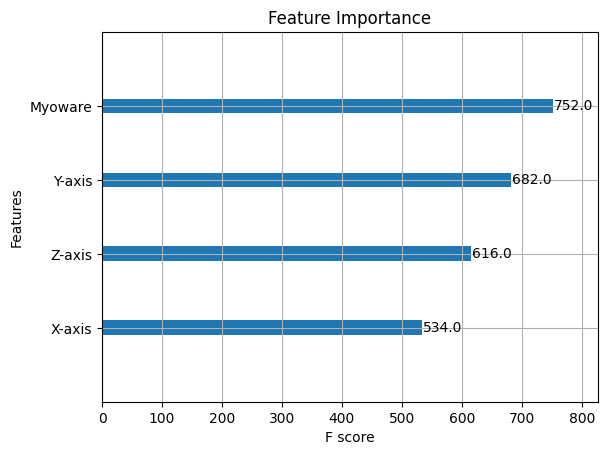

In [8]:
# Important Feature Visualization
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

In [9]:
# Create the LightGBM classifier (suppressing logs)
model = lgb.LGBMClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)


[LightGBM] [Info] Number of positive: 1860, number of negative: 2140
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.465000 -> initscore=-0.140229
[LightGBM] [Info] Start training from score -0.140229


In [10]:
# Performance Metric
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the LightGBM Classifier: {accuracy*100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy of the LightGBM Classifier: 90.20%

Confusion Matrix:
[[512  30]
 [ 68 390]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       542
           1       0.93      0.85      0.89       458

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



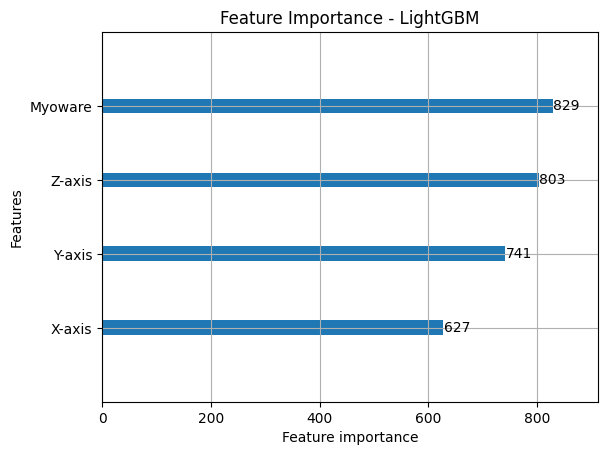

In [11]:
# Feature Importance Visualization (optional)
lgb.plot_importance(model, importance_type='split')
plt.title("Feature Importance - LightGBM")
plt.show()

In [12]:
# CatBoost
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the CatBoost Classifier: {accuracy*100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy of the CatBoost Classifier: 89.30%

Confusion Matrix:
[[511  31]
 [ 76 382]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       542
           1       0.92      0.83      0.88       458

    accuracy                           0.89      1000
   macro avg       0.90      0.89      0.89      1000
weighted avg       0.90      0.89      0.89      1000



In [14]:
# Define base models
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True))
]

In [15]:
# Define Stacking Classifier
stacking_m = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression()
)


In [16]:
# Train the model
stacking_m.fit(X_train, y_train)

# Make predictions
y_pred = stacking_m.predict(X_test)

In [17]:
#Stacking
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Stacking Classifier: {accuracy*100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy of the Stacking Classifier: 92.40%

Confusion Matrix:
[[512  30]
 [ 46 412]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       542
           1       0.93      0.90      0.92       458

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



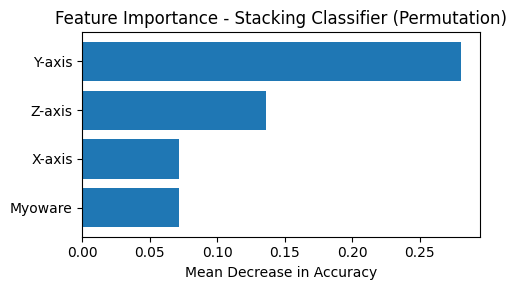

In [18]:
# Compute permutation importance
result = permutation_importance(stacking_m, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

# Extract and sort importance
importance_means = result.importances_mean
sorted_idx = np.argsort(importance_means)

# Plot
plt.figure(figsize=(5, 3))
plt.barh(range(len(sorted_idx)), importance_means[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title("Feature Importance - Stacking Classifier (Permutation)")
plt.xlabel("Mean Decrease in Accuracy")
plt.tight_layout()
plt.show()
